# chloride module example

In [1]:
%matplotlib inline
from rational_rc.chloride import ChlorideModel, load_df_D_RCM, C_crit_param, C_eqv_to_C_S_0
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# raw data
class Param: pass

pars_raw = Param()

pars_raw.marine = False

# 1)marine or coastal
pars_raw.C_0_M = 18.980 # natural chloride content of sea water [g/l]
  
# 2) de-icing salt (hard to quantify)
pars_raw.C_0_R = 0  # average chloride content of the chloride contaminated water [g/l]
pars_raw.n = 0      # average number of salting events per year [-]
pars_raw.C_R_i = 0  # average amount of chloride spread within one spreading event [g/m2]
pars_raw.h_S_i = 1  # amount of water from rain and melted snow per spreading period [l/m2]

pars_raw.C_eqv_to_C_S_0 = C_eqv_to_C_S_0 # imported correlation function for chloride content from soluiton to concrete

pars_raw.exposure_condition = 'splash'
pars_raw.exposure_condition_geom_sensitive = True
pars_raw.T_real = 273 + 25  # averaged ambient temperature[K]

pars_raw.x_a = 10.
pars_raw.x_h = 10.
pars_raw.D_RCM_test = 'N/A'
pars_raw.concrete_type = 'Portland cement concrete'
pars_raw.cement_concrete_ratio = 300./2400.
pars_raw.C_max_user_input = None
pars_raw.C_max_option = 'empirical'
pars_raw.C_0 = 0

pars_raw.C_crit_distrib_param = C_crit_param()  # critical chloride content import from Chloride module 0.6 wt.% cement (mean value)

# more options
pars_raw.option = Param()
pars_raw.option.choose = True
pars_raw.option.cement_type = 'CEM_I_42.5_R+SF'
pars_raw.option.wc_eqv = 0.4    # equivalent water/binder ratio
pars_raw.option.df_D_RCM_0 = load_df_D_RCM()

Pf(g = R-S < 0) from various methods
    sample count: 0.52303
    g integral: 0.5250313143363667
    R S integral: 0.5248762860330419
    beta_factor: -0.30656355108126127
-0.26621582320192305 0.6133863073737166


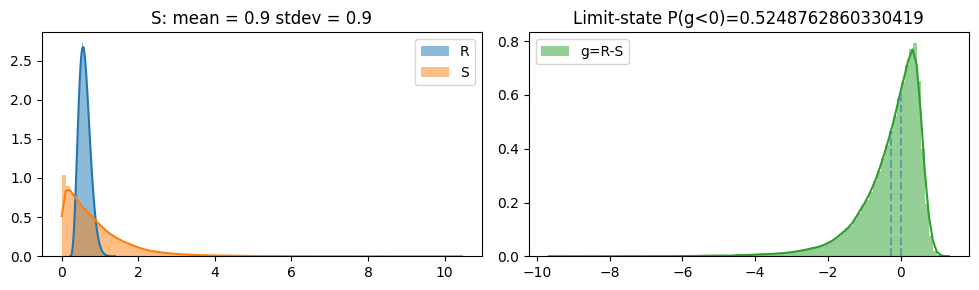

In [3]:
# initialize model
model_cl = ChlorideModel(pars_raw)

# run for 40 mm and 10 year
model_cl.run(x = 40, t = 10)

# postproc
model_cl.postproc(plot=True)

In [4]:
np.mean(model_cl.pf)

0.5248762860330419

In [5]:
# Calibration
# field data at three depth at t = 10 years
chloride_content_field = pd.DataFrame()
chloride_content_field['depth'] = [12.5, 50, 100]  # [mm]
chloride_content_field['cl'] = np.array([0.226, 0.04, 0.014]) / pars_raw.cement_concrete_ratio  # chloride_content[wt.-%/cement]
print(chloride_content_field)

   depth     cl
0   12.5  1.808
1   50.0  0.320
2  100.0  0.112


In [6]:
#calibrate model to the field chloride content
model_cl_cal = model_cl.calibrate(10, chloride_content_field,print_proc=False, plot=False) 

7.932128906250002e-13
2.917236328125e-12
2.999267578125e-12


Pf(g = R-S < 0) from various methods
    sample count: 0.2442
    g integral: 0.24753247206490384
    R S integral: 0.24757288096319238
    beta_factor: 0.18940800855341472
0.13818657169783283 0.4551735530677979


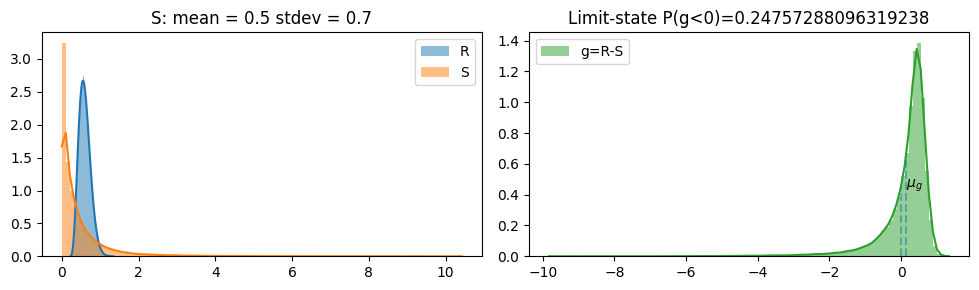

In [7]:
# run the calibrated model for 40 mm and 10 year
model_cl_cal.run(x = 40, t = 10)
model_cl_cal.postproc(plot=True)
# plt.savefig('chloride_at_rebar_40year.pdf',dpi=1200)

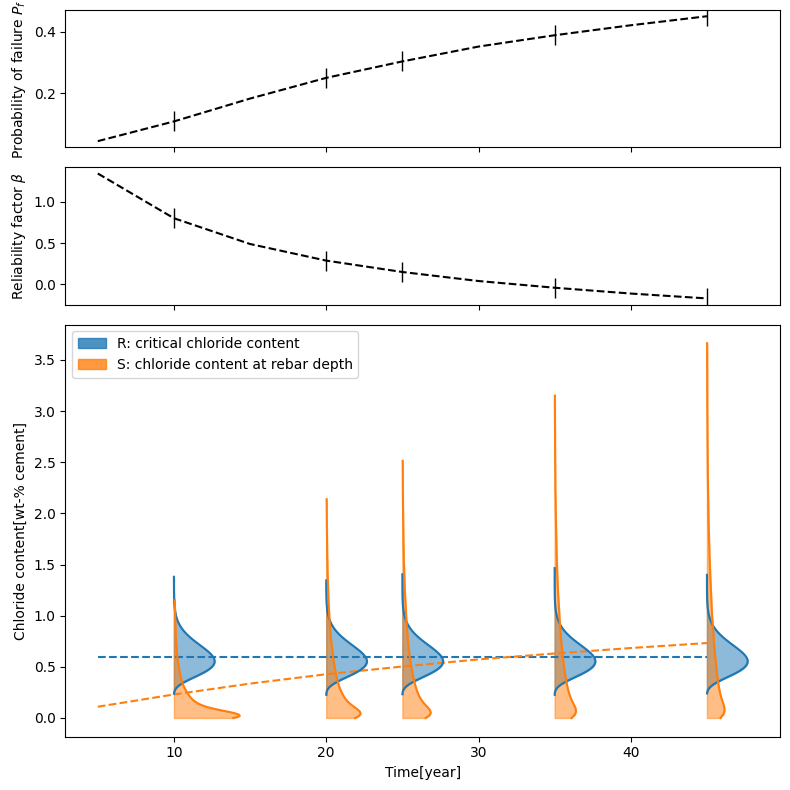

In [8]:
# run model for a list of time steps
t_lis = np.arange(5,50,5)
cover = 50
pf_lis, beta_lis = model_cl_cal.chloride_with_year(depth=cover, year_lis=t_lis,amplify=1)
# fig.savefig('RS_time_chloride.pdf',dpi=1200)
